In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
from natsort import natsorted
import pandas as pd

import numpy as np
from trajectory_utils import latToScale, latlonToMercator

In [2]:
def convertOxtsToPose(oxts):
    ''' converts a list of oxts measurements into metric poses,
    starting at (0,0,0) meters, OXTS coordinates are defined as
    x = forward, y = right, z = down (see OXTS RT3000 user manual)
    afterwards, pose{i} contains the transformation which takes a
    3D point in the i'th frame and projects it into the oxts
    coordinates with the origin at a lake in Karlsruhe. '''

    oxts = np.array(oxts)
    # single_value = not isinstance(oxts, list)
    # if single_value:
    #     oxts = [oxts]
    
    # origin in OXTS coordinate
    origin_oxts = [oxts[0][0], oxts[0][1]] # lake in Karlsruhe
    
    # compute scale from lat value of the origin
    scale = latToScale(origin_oxts[0])
    
    # origin in Mercator coordinate
    ox,oy = latlonToMercator(origin_oxts[0],origin_oxts[1],scale)
    origin = np.array([ox, oy, oxts[0][2]])
    
    pose     = []
    
    # for all oxts packets do
    for i in range(len(oxts)):
        
        # if there is no data => no pose
        if not len(oxts[i]):
            pose.append([])
            continue
    
        # translation vector
        tx, ty = latlonToMercator(oxts[i][0],oxts[i][1],scale)
        t = np.array([tx, ty, oxts[i][2]])
    
        # rotation matrix (OXTS RT3000 user manual, page 71/92)
        rx = oxts[i][3] # roll
        ry = oxts[i][4] # pitch
        rz = oxts[i][5] # heading
        Rx = np.array([[1,0,0],[0,np.cos(rx),-np.sin(rx)],[0,np.sin(rx),np.cos(rx)]]) # base => nav  (level oxts => rotated oxts)
        Ry = np.array([[np.cos(ry),0,np.sin(ry)],[0,1,0],[-np.sin(ry),0,np.cos(ry)]]) # base => nav  (level oxts => rotated oxts)
        Rz = np.array([[np.cos(rz),-np.sin(rz),0],[np.sin(rz),np.cos(rz),0],[0,0,1]]) # base => nav  (level oxts => rotated oxts)
        R  = np.matmul(np.matmul(Rz, Ry), Rx)
        
        # normalize translation
        t = t-origin
        
        # add pose
        pose.append(np.vstack((np.hstack((R,t.reshape(3,1))),np.array([0,0,0,1]))))
    
    # if single_value:
    #     pose = pose[0]
    
    return pose

In [3]:
def read_calib_file(calib_filepath):
    calib = {}
    with open(calib_filepath) as f:
        for line in f.readlines():
            line = line.strip()
            if len(line) == 0:
                continue
            k, v = line.split(':')
            calib[k] = np.array([float(x) for x in v.split()])
    return calib

def cart_to_homo(pts_3d):
    '''Convert Cartesian 3D points to Homogeneous 4D points.

    Args:
        pts_3d: nx3 points in Cartesian coord.

    Returns:
        nx4 points in Homogeneous coord.
    '''
    n = pts_3d.shape[0]
    return np.hstack([pts_3d, np.ones((n, 1))])

In [4]:
cam_cam = read_calib_file('./data/2011_09_26/calib_cam_to_cam.txt')
imu_velo = read_calib_file('./data/2011_09_26/calib_imu_to_velo.txt')
velo_cam = read_calib_file('./data/2011_09_26/calib_velo_to_cam.txt')

RT_imu_to_velo = np.hstack((imu_velo['R'].reshape(3,3), imu_velo['T'].reshape(3,1)))
# RT_imu_to_velo = np.vstack((RT_imu_to_velo, np.zeros((1, RT_imu_to_velo.shape[1]))))
# RT_imu_to_velo[3,3] = 1

RT_velo_to_cam = np.hstack((velo_cam['R'].reshape(3,3), velo_cam['T'].reshape(3,1)))
RT_velo_to_cam[:3,3] = np.array([0,0,0])
# RT_velo_to_cam = np.vstack((RT_velo_to_cam, np.zeros((1, RT_velo_to_cam.shape[1]))))
# RT_velo_to_cam[3,3] = 1

R_rect_00 = cam_cam['R_rect_00'].reshape(3,3)
# R_rect_00 = np.hstack((R_rect_00, np.zeros((R_rect_00.shape[0], 1))))
# R_rect_00 = np.vstack((R_rect_00, np.zeros((1, R_rect_00.shape[1]))))
# R_rect_00[3,3] = 1

P_rect_02 = cam_cam['P_rect_02'].reshape(3,4)

In [5]:
# 데이터 로딩
base_path = os.path.abspath('')
dir_path = os.path.join(base_path, 'data/2011_09_26/2011_09_26_drive_0001_sync/oxts/data/')
files = natsorted(os.listdir(dir_path))

all_data = []
for file in files:
    f = open(os.path.join(dir_path, file), 'r')
    # f = open(os.path.join(base_path, 'oxts/data/', file), 'r')
    lines = f.readlines()
    for line in lines:
        line = line.strip()  # 줄 끝의 줄 바꿈 문자를 제거한다.
        line = line.split()
        line = np.array(line, dtype=np.float32)
    all_data.append(line)
    
df = pd.DataFrame(all_data)

# print(df)
pose = np.array(convertOxtsToPose(df))

trans = pose[:,:3,3]
trans[:,0] = -(trans[:,0])
trans[:,1] = -(trans[:,1])

In [6]:
relative = []

for i in range(1, len(pose)):
    relative.append(-(np.dot(np.linalg.inv(pose[0]), pose[i])[:3, 3]))
    
relative = np.array(relative)
relative[:,2] = relative[:,2]-1.65

In [7]:
import open3d as o3d

def show_open3d_pcd(pcd_list, show_origin=True, origin_size=3, show_grid=True):
    geometries = []
    v3d = o3d.utility.Vector3dVector
    
    for pcd in pcd_list:
        if isinstance(pcd, np.ndarray):
            cloud = o3d.geometry.PointCloud()
            cloud.points = v3d(pcd)
            geometries.append(cloud)
        elif isinstance(pcd, o3d.geometry.PointCloud):
            geometries.append(pcd)
            
    
    if show_origin:
        coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=origin_size, origin=np.array([0.0, 0.0, 0.0]))
        geometries.append(coord)
    
    o3d.visualization.draw_geometries(geometries)
    
show_open3d_pcd([relative])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


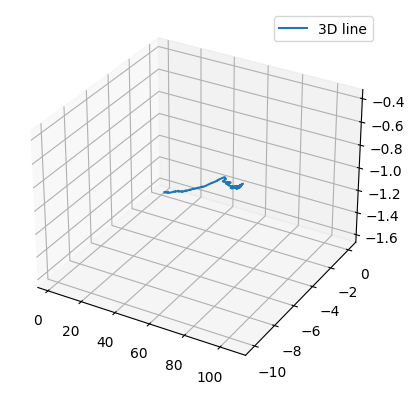

In [14]:
# 좌표 분리
x = relative[:, 0]
y = relative[:, 1]
z = relative[:, 2]

# 3D 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 선으로 잇기
ax.plot(x, y, z, label='3D line')
ax.legend()

# 그래프 보이기
plt.show()

In [8]:
def expand_trajectory(trajectory, width=1.0):
    # 궤적을 입력받아 폭을 가진 메쉬로 확장하는 함수
    expanded_points = []
    for i in range(len(trajectory) - 1):
        # 궤적의 인접한 두 점을 사용하여 폭을 계산하고 확장된 점들을 생성
        x1, y1, z1 = trajectory[i]
        x2, y2, z2 = trajectory[i + 1]
        dx = x2 - x1
        dy = y2 - y1
        length = np.sqrt(dx**2 + dy**2)
        nx = -dy / length
        ny = dx / length
        left_x1 = x1 + nx * width
        left_y1 = y1 + ny * width
        right_x1 = x1 - nx * width
        right_y1 = y1 - ny * width
        left_x2 = x2 + nx * width
        left_y2 = y2 + ny * width
        right_x2 = x2 - nx * width
        right_y2 = y2 - ny * width
        expanded_points.append([left_x1, left_y1, z1])
        expanded_points.append([right_x1, right_y1, z1])
        expanded_points.append([left_x2, left_y2, z2])
        expanded_points.append([right_x2, right_y2, z2])
    
    expanded_points = np.array(expanded_points)
    
    # 확장된 점들을 이용하여 삼각형 메쉬 생성
    triangles = []
    for i in range(0, len(expanded_points) - 2, 2):
        triangles.append([i, i + 1, i + 2])
        triangles.append([i + 1, i + 3, i + 2])
    
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(expanded_points)
    mesh.triangles = o3d.utility.Vector3iVector(triangles)
    mesh.paint_uniform_color([0, 1, 0])  # 녹색으로 색상 지정
    
    return mesh

def show_open3d_pcd(pcd_list, show_origin=True, origin_size=3, show_grid=True):
    # Open3D로 점구름 및 메쉬를 시각화하는 함수
    geometries = []
    v3d = o3d.utility.Vector3dVector
    
    for i, pcd in enumerate(pcd_list):
        if isinstance(pcd, o3d.geometry.TriangleMesh):
            geometries.append(pcd)
        elif isinstance(pcd, np.ndarray):
            cloud = o3d.geometry.PointCloud()
            cloud.points = v3d(pcd)
            geometries.append(cloud)
        elif isinstance(pcd, o3d.geometry.PointCloud):
            geometries.append(pcd)
    
    if show_origin:
        coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=origin_size, origin=np.array([0.0, 0.0, 0.0]))
        geometries.append(coord)
    
    o3d.visualization.draw_geometries(geometries)

expanded_trajectory = expand_trajectory(relative, width=1.0)
show_open3d_pcd([expanded_trajectory])

In [9]:
show_open3d_pcd([np.asarray(expanded_trajectory.vertices)])

In [9]:
for i in range(len(relative)):
    dis = (relative[i, 0]**2 + relative[i, 1]**2 + relative[i, 2]**2)**0.5
    if dis>50:
        break
    idx=i
relative = relative[:idx]

In [10]:
Tr_imu_to_velo = np.vstack((RT_imu_to_velo, np.zeros((1, RT_imu_to_velo.shape[1]))))
Tr_imu_to_velo[3, 3] = 1

Tr_velo_to_cam = np.vstack((RT_velo_to_cam, np.zeros((1, RT_velo_to_cam.shape[1]))))
Tr_velo_to_cam[3, 3] = 1

R_rect_00 = np.hstack((R_rect_00, np.zeros((R_rect_00.shape[0], 1))))
R_rect_00 = np.vstack((R_rect_00, np.zeros((1, R_rect_00.shape[1]))))

one = np.vstack((relative.T, np.ones((1, relative.T.shape[1]))))
# two = np.dot(Tr_imu_to_velo, one)
three = np.dot(Tr_velo_to_cam, one)

four = np.dot(R_rect_00, three)
five = np.dot(P_rect_02, four)

lidar_proj = five.T
lidar_proj[:, 0] /= lidar_proj[:, 2]
lidar_proj[:, 1] /= lidar_proj[:, 2]
lidar_pixel_coord = lidar_proj[:, 0:2]
lidar_pixel_depth = lidar_proj[:, 2]

In [11]:
import cv2
import numpy as np

# 이미지 불러오기
img = cv2.imread('data/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000000.png')

# cnt와 points 초기화
cnt = 0
points = []

# 빨간 점 찍기 및 점들 리스트에 저장
for i in lidar_pixel_coord:
    cnt += 1
    if cnt < 5:
        continue
    
    point = (np.floor(i[0]).astype(np.int32), np.floor(i[1]).astype(np.int32))
    points.append(point)
    img[point[1], point[0]] = np.array([0, 0, 255])

# 점들을 선으로 연결하기
for j in range(len(points) - 1):
    cv2.line(img, points[j], points[j + 1], (0, 0, 255), 2)

# 이미지 출력
cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
